# Import general libraries


In [1]:
# Import libraries
import sys
import os
import json 
import pandas as pd
import matplotlib.pylab as plt


In [2]:
print("Current directory :", os.getcwd())
test_directory = os.getcwd()
os.chdir("./..")
print("Changed to directory :", os.getcwd())

Current directory : /Users/alaukiksaxena/Calculations/20240625_Nfdi/CompositionSpaceNFDI/tests
Changed to directory : /Users/alaukiksaxena/Calculations/20240625_Nfdi/CompositionSpaceNFDI


# Import tools

In [3]:
from compositionspace.datautils import DataPreparation
from compositionspace.segmentation import CompositionClustering
from compositionspace.postprocessing import DataPostprocess

### Read the inputs (experiment parameters)

# 1. Pre-processing

* Reading the reconstruction data (spatial coordintes of ions)(.APT, .POS, .csv)
* Reading range file (.rrng)
* concacting chemical species to each ion using the mass to charge ratio ranges from the range file(.rrng).
* Spatially discretize the reconstructed data into slices. (Especially useful if the original data is very large)
* Voxelize each slice
* Calculate the composition of each voxel( in atomic fraction)

A. Input defined in "experiment_params.yaml" 
*  **input_path: tests/datapath** 
*  **n_big_slices: 10**: Number of slices perpendicular to axis of reconstructed data
*  **voxel_size: 2**: Voxel size(cube) in nm
*  input path must contain .APT(or.POS, .csv) and .rrng

B. Output defined in "experiment_params.yaml"
*  **output_path: output**
*  get_big_slices>>(.h5) : 
    1. Atomic coordinates in each slice (x,y,z)
    2. Chemical identities per atom (Da, spec)
    3. Atributes : coloumns, mass to charge states ,type of chemical species
* get_voxels>>(.h5):
    1. Atomic coordinates in each voxel(x,y,z)
    2. Chemical identities per atom (spec)
    3. Atributes : coloumns, type of chemical species, Total number of voxels
* calculate_voxel_composition>>(.h5):
    1. Coordinates of each voxel centroid (x,y,z)
    2. atomic fraction of each chemical species 



In [4]:
data = DataPreparation(test_directory + "/experiment_params.yaml")
data.get_big_slices()
data.get_voxels()
data.calculate_voxel_composition()

Reading files:   0%|          | 0/2 [00:00<?, ?it/s]

Creating chunks:   0%|          | 0/10 [00:00<?, ?it/s]

Getting Voxels:   0%|          | 0/10 [00:00<?, ?it/s]

Calculating voxel composition:   0%|          | 0/8846 [00:00<?, ?it/s]

In [5]:
data.chunk_files

['output/file_R31_06365-v02_pos_large_chunks_arr.h5']

In [6]:
data.voxel_files

['output/file_R31_06365-v02_pos_small_chunks_arr.h5']

In [7]:
data.voxel_ratio_file

'output/output_vox_ratio_composition.h5'

# 2. Clustering in composition space

* Calculate contribution of each species towards variance in composition (using PCA)(Also helps to guage importance of a certain chemical species in the data)

* For a certain clustering algorithm perform minimisation of BIC and AIC (to guage model complexity vs information) (to get the optimum number of clusters)
* Use Gaussian mixture models (GMM) to perform clustering in composition space with the number of clusters from the previous step. 

A. Input defined in "experiment_params.yaml" 
*  **bics_clusters: 10**: Number of clusters for which bics/aics is calculated
*  **n_phases: 2**: number of phases based on bics elbow critieria
*  **GaussianMixture: n_components:2 max_iter: 100000 ** : GMM is used for clustering with 2 components(n_components), The number of EM iterations to perform (max_iter) 

B. Output defined in "experiment_params.yaml"
*  **output_path: output**

*  get_PCA_cumsum>>(.jpg) : 
    * Explained variance vs Dimensions

* get_bics_minimization>>(.jpg):
    * Bic/Aic vs number of clusters
* get_composition_clusters>>(.h5):
    * Voxel positions and compostion (per phase)
* generate_plots>>(.vtu):
    * 3D Plots of voxel position per phase in real space 




8846
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', 'Total_no', 'vox']


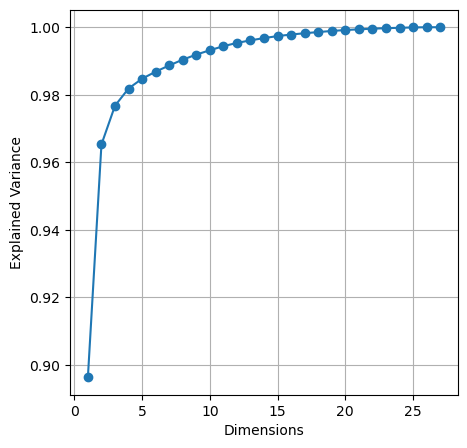

In [8]:
comps = CompositionClustering(test_directory + "/experiment_params.yaml")
res = comps.get_PCA_cumsum(data.voxel_ratio_file, data.voxel_files[0])

Clustering:   0%|          | 0/9 [00:00<?, ?it/s]

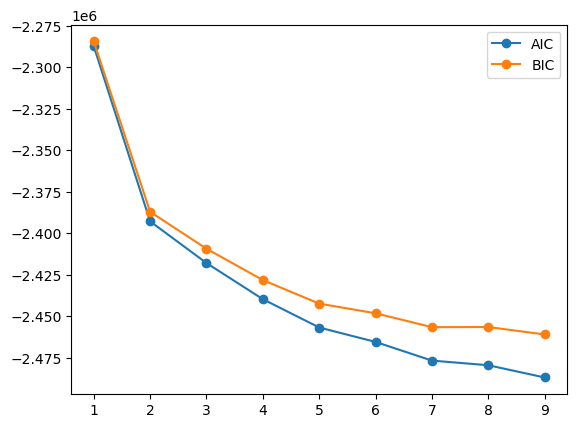

In [9]:
res = comps.get_bics_minimization(data.voxel_ratio_file, data.voxel_files[0])

In [10]:
comps.get_composition_clusters(data.voxel_ratio_file, data.voxel_files[0])

In [11]:
comps.generate_plots()

# 3. Postprocessing
* Clean the precipitates/chemical domains of diffrent phases from the noisy voxels
* Segment out each precipitate in 3D 

A. Input defined in "experiment_params.yaml" 

*  **DBScan: eps: 3 min_samples: 5** : DBScan is used for clustering with core radius(eps) and minmum data points in the radius as  min_samples

B. Output defined in "experiment_params.yaml"
*  **output_path: output**

*  DBSCAN_clustering>>(.jpg, .vtu, .h5) : 
    1. Clustering histogram for a given value of eps and min_samples (.jpg)
    2. Different precipitates voxels centroids (x,y,z) are stored (.h5)
    3. Precipitates are visualised using parview (.vtu)



In [12]:
pdata = DataPostprocess(test_directory + "/experiment_params.yaml")

  0%|          | 0/31 [00:00<?, ?it/s]

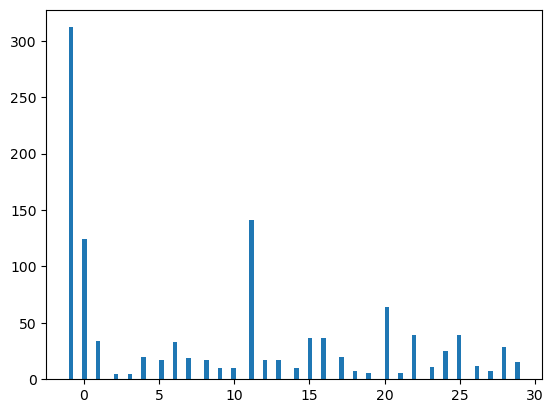

In [13]:
pdata.DBSCAN_clustering(comps.voxel_centroid_output_file, cluster_id = 0,
                        plot=True, plot3d=True, save=True)